In [1]:
import os
import shutil

import dlib
import cv2
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
import tensorflow as tf

from keras import applications, optimizers, Input
from keras.models import Sequential, Model
from keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D
from keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

%matplotlib inline

Using TensorFlow backend.


In [2]:
def coin_regions(img, x1, y1, x2, y2):
    return img[y1:y2, x1:x2]

In [3]:
def create_dataset(dataset_type):
    """
        createDataset:
        - This script creates dataset with JUST COINS (64x64).
        It's necessary to especify the directory where the full images are stored.
        The directory should contain sub-directories as fallow: '5', '10', '25', '50', '100'
        
        arg:
        - dataset_type:
            0: create train dataset
            1: create test dataset
    """
    
    if dataset_type == 0:
        folder_src = r'../train'
        folder_out = r'../train2'
    elif dataset_type == 1:
        folder_src = r'../test'
        folder_out = r'../test2'
    
    # hog_detector made with dlib. More trainning improves detection
    detector = dlib.simple_object_detector("hog_detector.svm")
    
    # Create directory to store ONLY COINS
    if os.path.exists('{}'.format(folder_out)):
        shutil.rmtree('{}'.format(folder_out))
    else:
        os.makedirs('{}'.format(folder_out))
    
    # Extract and store coins into right folder
    for coin_directory in os.listdir('{}'.format(folder_src)):
        os.makedirs('{}/{}'.format(folder_out, coin_directory))
        
        train_images_type = []
        for coin_image in os.listdir('{}/{}'.format(folder_src, coin_directory)):
            img = cv2.imread('{}/{}/{}'.format(folder_src, coin_directory, coin_image))
            gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
            blur = cv2.GaussianBlur(gray, (3,3), 2)
            rects = detector(blur)

            if len(rects) > 0:
                left, top, right, bottom = rects[0].left(), rects[0].top(), rects[0].right(), rects[0].bottom()
                coin_region = coin_regions(img, left, top, right, bottom)
                coin_region = np.array(coin_region)
                
                if (coin_region.shape[0] != 0 and coin_region.shape[1] != 0 and coin_region.shape[2] != 0):
                    coin_region = cv2.resize(coin_region,(64,64))
                    train_images_type.append(coin_region)

        for i, image in enumerate(train_images_type):
            cv2.imwrite('{}/{}/{}.jpg'.format(folder_out, coin_directory, i), image)

In [4]:
# Create train and test dataset
create_dataset(0)
create_dataset(1)

In [5]:
def create_CNN():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), input_shape=(64, 64, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(data_format="channels_last", pool_size=(2, 2)))

    model.add(Conv2D(32, (3, 3)))
    model.add(Activation('relu')) 
    model.add(MaxPooling2D(data_format="channels_last", pool_size=(2, 2)))

    model.add(Conv2D(64, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(data_format="channels_last", pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dense(64))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(5))
    model.add(Activation('softmax'))

    model.compile(loss='categorical_crossentropy',
                  optimizer='adadelta',
                  metrics=['accuracy'])

    return model

In [6]:
def coins_numbers(coins):
    """
        coins_numbers:
        - return the frequency of a certain coin.
        
        arg:
        - coins: list of images with coin region
    """
    total_coins = {
        '5': 0,
        '10': 0,
        '25': 0,
        '50': 0,
        '100': 0
    }
    
    for coin in coins:
        coin = cv2.resize(coin, (64, 64))
        
        plt.imshow(coin)
        plt.show()
        
        coin = np.reshape(coin, [1, 64, 64, 3])
        coin = np.asarray(coin)
        
        coin_type = model.predict_classes(coin)
        if coin_type[0] == 0:
            print('Moeda: 10 centavos')
            total_coins['10'] += 1
        elif coin_type[0] == 1:
            print('Moeda: 1 real')
            total_coins['100'] += 1
        elif coin_type[0] == 2:
            print('Moeda: 25 centavos')
            total_coins['25'] += 1
        elif coin_type[0] == 3:
            print('Moeda: 5 centavos')
            total_coins['5'] += 1
        elif coin_type[0] == 4:
            print('Moeda: 50 centavos')
            total_coins['50'] += 1
    
    return total_coins

In [7]:
# Create model, configure train and test dataset
model = create_CNN()

batch_size = 16
train_datagen = ImageDataGenerator(
        rotation_range=180,
        width_shift_range=0.05,
        height_shift_range=0.05,
        shear_range=0.05,
        rescale=1./255,
        zoom_range=0.1,
        fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        '../train2',
        target_size=(64, 64),
        color_mode="rgb",
        batch_size=batch_size,
        class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
        '../test2',
        target_size=(64, 64),
        color_mode="rgb",
        batch_size=batch_size,
        class_mode='categorical')

Found 609 images belonging to 5 classes.
Found 104 images belonging to 5 classes.


In [8]:
model.fit_generator(
        train_generator,
        steps_per_epoch=200 // batch_size,
        epochs=30,
        validation_data=validation_generator,
        validation_steps=200 // batch_size)

Epoch 1/30
12/12 [==============================] - 5s 433ms/step - loss: 1.6153 - acc: 0.2500 - val_loss: 1.6131 - val_acc: 0.2174
Epoch 2/30
12/12 [==============================] - 2s 166ms/step - loss: 1.5872 - acc: 0.2604 - val_loss: 1.5678 - val_acc: 0.2898
Epoch 3/30
12/12 [==============================] - 2s 181ms/step - loss: 1.6371 - acc: 0.2188 - val_loss: 1.5993 - val_acc: 0.2159
Epoch 4/30
12/12 [==============================] - 2s 170ms/step - loss: 1.6096 - acc: 0.2254 - val_loss: 1.5500 - val_acc: 0.2554
Epoch 5/30
12/12 [==============================] - 2s 156ms/step - loss: 1.5563 - acc: 0.3385 - val_loss: 1.6217 - val_acc: 0.1989
Epoch 6/30
12/12 [==============================] - 2s 171ms/step - loss: 1.5359 - acc: 0.2969 - val_loss: 1.6107 - val_acc: 0.3295
Epoch 7/30
12/12 [==============================] - 2s 141ms/step - loss: 1.4470 - acc: 0.4338 - val_loss: 1.3735 - val_acc: 0.3807
Epoch 8/30
12/12 [==============================] - 2s 148ms/step - loss: 1.

In [9]:
#model.save('coin_classifier_v1.h5')
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 62, 62, 32)        896       
_________________________________________________________________
activation_1 (Activation)    (None, 62, 62, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 29, 29, 32)        9248      
_________________________________________________________________
activation_2 (Activation)    (None, 29, 29, 32)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 12, 12, 64)        18496     
__________

In [10]:
print(model.evaluate_generator(validation_generator, steps = 32), end='\n\n')
print(train_generator.class_indices)

[0.7917222400506337, 0.6208333333333333]

{'10': 0, '100': 1, '25': 2, '5': 3, '50': 4}


In [11]:
from keras import models
model = models.load_model('coin_classifier_v1.h5')

def main():
    # hog_detector made with dlib. More trainning improves detection
    detector = dlib.simple_object_detector("hog_detector.svm")

    # show generalized HOG model for a coin
    win_det = dlib.image_window()
    win_det.set_image(detector)
    
    # Processing image input to detect coins on it
    img = cv2.imread('../images/coin4.jpg')[:, :, ::-1]
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    blur = cv2.GaussianBlur(gray, (3,3), 2)

    rects = detector(blur)
    
    coins = []
    for k, d in enumerate(rects):
        coins.append(coin_regions(img, d.left(), d.top(), d.right(), d.bottom()))
    
    #for i, coin in enumerate(coins):
    #    cv2.imwrite('paper/{}.png'.format(i), coin[:, :, ::-1])
    
    coins_a = coins_numbers(coins)
    
    plt.imshow(img)
    plt.show()
    
    print('\n\nQuantidade de moedas: {}'.format(len(rects)))
    print(coins_a)
    
    total = 5*coins_a['5'] + 10*coins_a['10'] + 25*coins_a['25'] + 50*coins_a['50']+100*coins_a['100']
    print('Total: {:.2f} reais'.format(total/100))

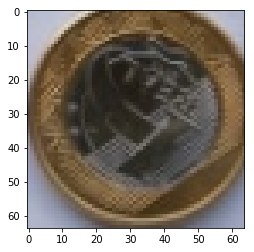

Moeda: 1 real


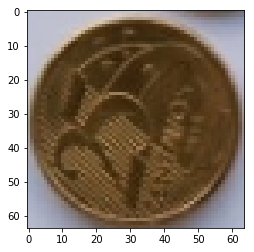

Moeda: 25 centavos


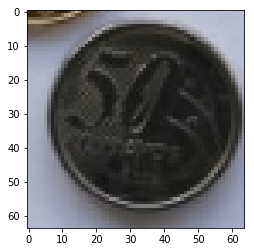

Moeda: 50 centavos


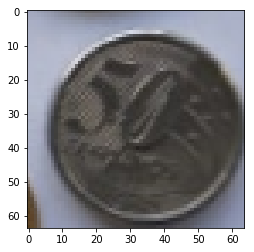

Moeda: 50 centavos


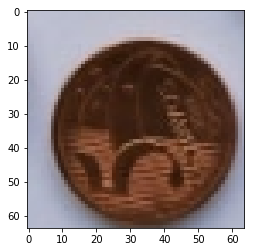

Moeda: 5 centavos


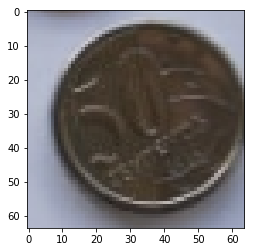

Moeda: 50 centavos


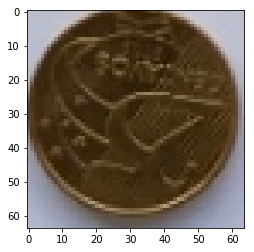

Moeda: 5 centavos


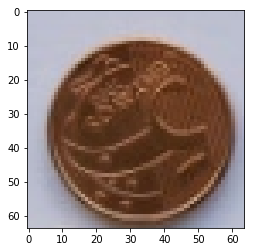

Moeda: 5 centavos


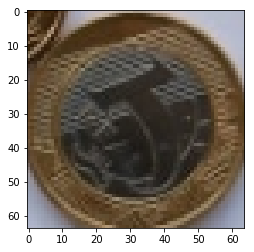

Moeda: 1 real


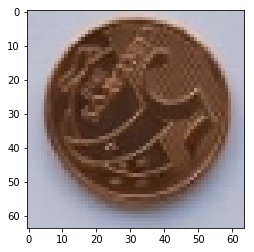

Moeda: 5 centavos


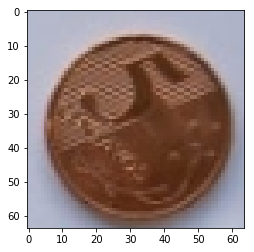

Moeda: 5 centavos


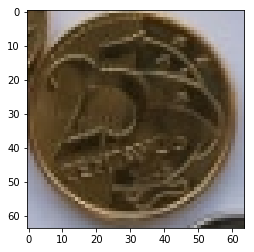

Moeda: 25 centavos


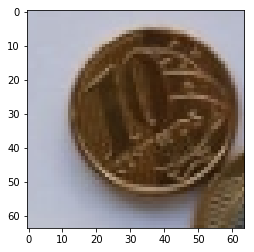

Moeda: 25 centavos


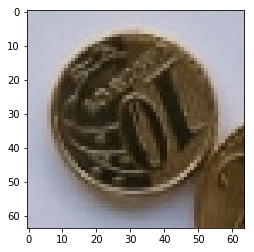

Moeda: 50 centavos


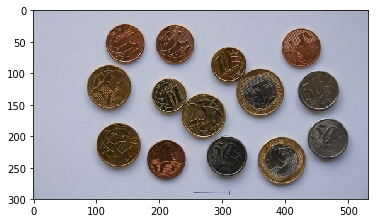



Quantidade de moedas: 14
{'5': 5, '10': 0, '25': 3, '50': 4, '100': 2}
Total: 5.00 reais


In [12]:
if __name__ == '__main__':
    main()

In [13]:
#
#
#
#
#
#
#
#
#
#
#
#
#
#
#
#
#
#
#
#

In [14]:
#from keras.preprocessing import image

# Charging image to evaluate in model
#test_image = image.load_img('../moedass3.png', target_size = (64, 64))
#test_image = image.img_to_array(test_image)
#test_image = np.expand_dims(test_image, axis = 0)

#result = model.predict_classes(test_image)
#result

#img = cv2.imread('../exemplo1.jpeg')[:, :, ::-1]
#img = cv2.resize(img,(64,64))
#img = np.reshape(img,[1,64,64,3])
#img = np.asarray(img)

In [15]:
#model = create_CNN()

#from keras.utils import plot_model
#plot_model(model, to_file='model.png')